In [8]:
import spacy
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load the SpaCy English language model
nlp = spacy.load("en_core_web_md")

In [4]:
corpus = pd.read_csv(os.path.join("..","data","presidential_speeches.csv"))

In [5]:
corpus_true = corpus[corpus['Party'].isin(['Democratic', 'Republican'])]
len(corpus_true)


867

In [9]:
def clean_data(corpus): 
    text = re.sub(r'\([^)]*\)', '', corpus) # Remove text between parentheses
    text = re.sub("[^A-Za-z]+", " ", text)  # Removes everything that is not words.
    # Return text in lowercase and stripped of whitespaces
    text = text.lower().strip()
    
    return text

In [10]:
corpus_true['cleaned'] = corpus_true['Transcript'].apply(lambda x: clean_data(x))

/tmp/ipykernel_8013/3484643261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_true['cleaned'] = corpus_true['Transcript'].apply(lambda x: clean_data(x))


In [11]:
speeches = corpus_true['cleaned'].tolist()

In [47]:
# Perform NER and extract entities from the speeches
speeches_entities = []
for speech in speeches:
    doc = nlp(speech)
    entities = [ent.text for ent in doc.ents]
    speeches_entities.append(entities)

In [48]:
corpus_true["NER"] = speeches_entities
# Add lemmatized speeches to the corpus_true DataFrame

/tmp/ipykernel_8013/1791914474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_true["NER"] = speeches_entities


In [49]:
vectorizer = TfidfVectorizer(
                            stop_words = "english",
                            max_features = 500,
                            ngram_range = (1,2),
                            min_df = 5,
                            max_df = 0.95)

In [50]:
X_train_feats = vectorizer.fit_transform([" ".join(entities) for entities in speeches_entities])


In [60]:
# Perform clustering using K-means

kmeans = KMeans(n_clusters=2).fit(X_train_feats)
cluster_labels = kmeans.labels_


/home/coder/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Sil score

In [53]:
from sklearn import metrics

In [61]:
dbi = metrics.davies_bouldin_score(X_train_feats.toarray(), cluster_labels)

# Compute Silhoutte Score
ss = metrics.silhouette_score(X_train_feats.toarray(), cluster_labels , metric='euclidean')

# Print the DBI and Silhoutte Scores
print("DBI Score: ", dbi, "\nSilhoutte Score: ", ss)

DBI Score:  3.4805684900060716 
Silhoutte Score:  0.06044504461930687


## elbow score

/home/coder/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


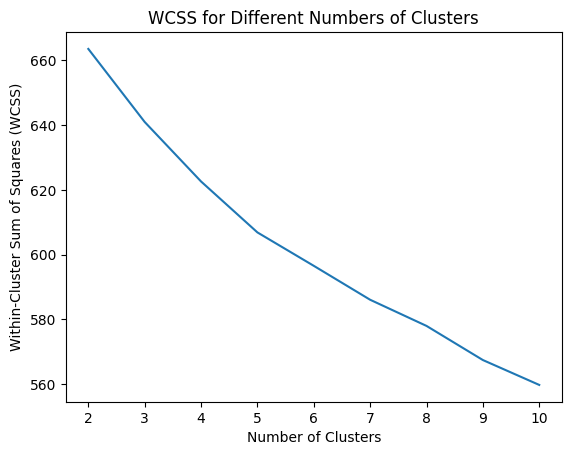

In [62]:
max_clusters = 10
wcss = []
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_feats)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.plot(range(2, max_clusters + 1), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('WCSS for Different Numbers of Clusters')
plt.show()


In [22]:
from sklearn.decomposition import PCA

https://builtin.com/data-science/step-step-explanation-principal-component-analysis

In [63]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_train_feats.toarray())

In [64]:
# Add PCA features to DataFrame
corpus_true['x0'] = pca_features[:, 0]
corpus_true['x1'] = pca_features[:, 1]

/tmp/ipykernel_8013/4249153657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_true['x0'] = pca_features[:, 0]
/tmp/ipykernel_8013/4249153657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_true['x1'] = pca_features[:, 1]


In [65]:
corpus_true['cluster'] = cluster_labels

/tmp/ipykernel_8013/3894098257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_true['cluster'] = cluster_labels


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
corpus_true

,Date,President,Party,Speech Title,Summary,Transcript,URL,cleaned,cluster,x0,x1,NER
94,1829-03-04,Andrew Jackson,Democratic,First Inaugural Address,President Jackson thanks the nation for its su...,Fellow Citizens: About to undertake the arduou...,https://millercenter.org/the-presidency/presid...,fellow citizens about to undertake the arduous...,1,0.273485,0.196544,"[the united states, congress, congress, a mill..."
95,1829-05-11,Andrew Jackson,Democratic,Proclamation Regarding Duties on Austrian Vessels,The President announces an agreement with Aust...,Whereas by an act of the Congress of the Unite...,https://millercenter.org/the-presidency/presid...,whereas by an act of the congress of the unite...,1,0.555154,-0.312733,"[the united states, the th of january, the uni..."
96,1829-12-08,Andrew Jackson,Democratic,First Annual Message to Congress,President Jackson begins with an overview of t...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,fellow citizens of the senate and house of rep...,1,0.497814,0.221813,"[senate, house of representative, first, the u..."
97,1830-05-06,Andrew Jackson,Democratic,Message Regarding Treaties with the Choctaw Na...,NaN,To the Senate of the United States. The accomp...,https://millercenter.org/the-presidency/presid...,to the senate of the united states the accompa...,1,0.109991,-0.083993,"[the united states, indians, the united states..."
98,1830-05-27,Andrew Jackson,Democratic,Veto Message Regarding Funding of Infrastructu...,"Jackson vetoes the Maysville Road bill, which ...",To the House of Representatives. I have mature...,https://millercenter.org/the-presidency/presid...,to the house of representatives i have maturel...,1,0.084941,0.564322,"[the maysville washington paris, lexington, co..."
...,...,...,...,...,...,...,...,...,...,...,...,...
987,2019-01-19,Donald Trump,Republican,Remarks about the US Southern Border,President Donald Trump speaks about what he se...,"Just a short time ago, I had the honor of pres...",https://millercenter.org/the-presidency/presid...,just a short time ago i had the honor of presi...,0,-0.100395,0.139097,"[five, american, americans, first, tenth, one,..."
988,2019-02-05,Donald Trump,Republican,State of the Union Address,"In his second State of the Union Address, Pres...","Madam Speaker, Mr. Vice President, Members of ...",https://millercenter.org/the-presidency/presid...,madam speaker mr vice president members of con...,0,-0.271107,0.147177,"[congress, first, the united states, americans..."
989,2019-02-15,Donald Trump,Republican,Speech Declaring a National Emergency,President Donald Trump declares a national eme...,"Thank you very much, everybody. Before we begi...",https://millercenter.org/the-presidency/presid...,thank you very much everybody before we begin ...,0,-0.056364,-0.160798,"[china, about two day, china, year, china, chi..."
990,2019-09-24,Donald Trump,Republican,Remarks at the United Nations General Assembly,President Donald Trump speaks to the 74th sess...,"Thank you very much. Mr. President, Mr. Secret...",https://millercenter.org/the-presidency/presid...,thank you very much mr president mr secretary ...,0,0.006226,-0.177330,"[seven decade, today, the united states, over ..."


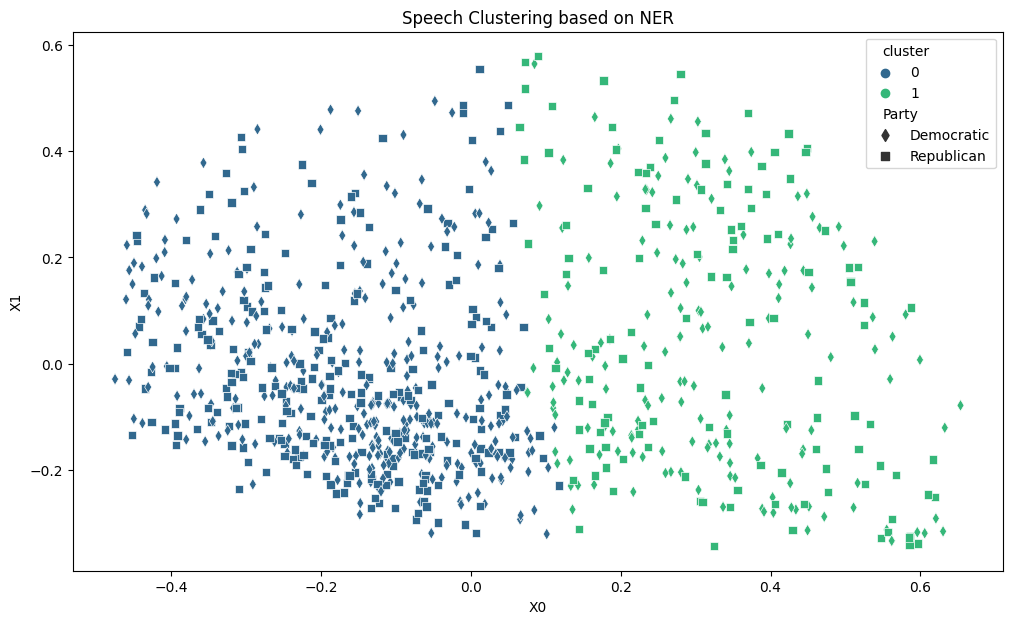

In [68]:
# Plot the clusters using a scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=corpus_true, x='x0', y='x1', hue='cluster', palette='viridis', style='Party', markers={'Democratic': 'd', 'Republican': 's'})
plt.title('Speech Clustering based on NER')
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

### Counting

In [69]:
counts = corpus_true.groupby(['cluster', 'Party']).size()
counts

cluster  Party     
0        Democratic    314
         Republican    258
1        Democratic    164
         Republican    131
dtype: int64

## FInd most common NERS for each cluster

In [35]:
from collections import Counter

In [70]:
# Analyze the most common NERs for each cluster
ner_count = []
for cluster in range(n_clusters):
    cluster_df = corpus_true[corpus_true['cluster'] == cluster]
    cluster_entities = [entity for entities in cluster_df['NER'] for entity in entities]
    entities_count = Counter(cluster_entities)
    most_common_ners = entities_count.most_common(10)  # Change the number to get more or fewer NERs
    print(f"Cluster {cluster}:")
    for ner, count in most_common_ners:
        ner_count.append((ner, count))
        print(f"- NER: {ner}, Count: {count}")
    print("--------------------")


Cluster 0:
- NER: american, Count: 4109
- NER: america, Count: 2981
- NER: congress, Count: 2534
- NER: today, Count: 1994
- NER: first, Count: 1976
- NER: the united states, Count: 1852
- NER: americans, Count: 1827
- NER: one, Count: 1707
- NER: tonight, Count: 1281
- NER: two, Count: 924
--------------------
Cluster 1:
- NER: the united states, Count: 5387
- NER: congress, Count: 4157
- NER: american, Count: 1527
- NER: one, Count: 1088
- NER: two, Count: 1023
- NER: first, Count: 972
- NER: mexico, Count: 785
- NER: senate, Count: 762
- NER: indian, Count: 513
- NER: britain, Count: 503
--------------------
Cluster 2:
--------------------
Cluster 3:
--------------------
Cluster 4:
--------------------
Cluster 5:
--------------------
Cluster 6:
--------------------
Cluster 7:
--------------------
Cluster 8:
--------------------
Cluster 9:
--------------------


# Elbow

/home/coder/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_8013/2348064403.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_true['x0'] = pca_features[:, 0]
/tmp/ipykernel_8013/2348064403.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_true['x1'] = pca_features[:, 1]
/tmp/ipykernel_8013/234806

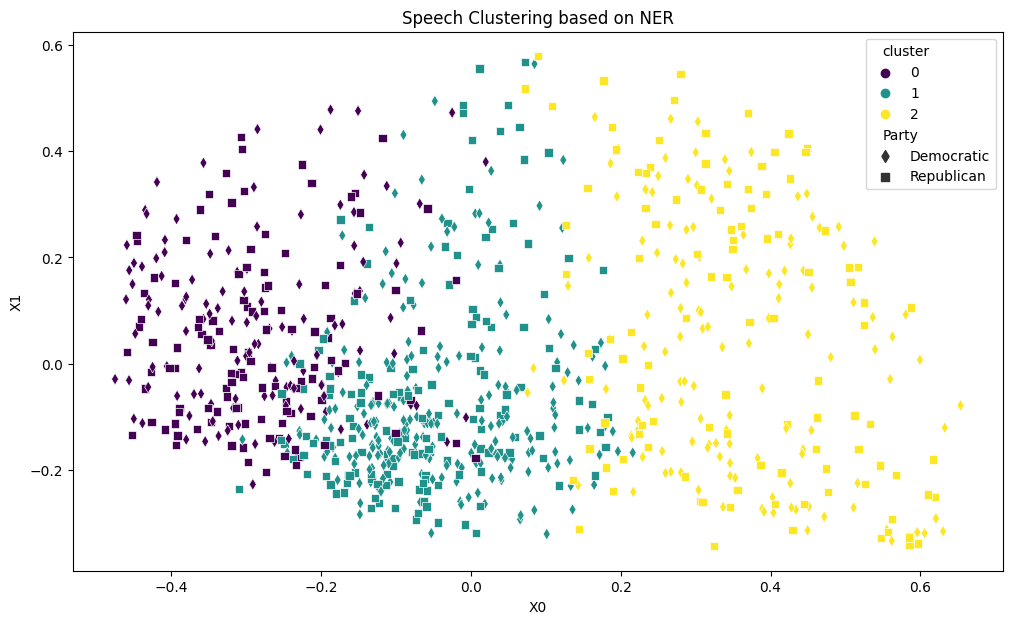

In [73]:
# Perform clustering using K-means

kmeans = KMeans(n_clusters=3).fit(X_train_feats)
cluster_labels = kmeans.labels_


# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_train_feats.toarray())



# Add PCA features to DataFrame
corpus_true['x0'] = pca_features[:, 0]
corpus_true['x1'] = pca_features[:, 1]



corpus_true['cluster'] = cluster_labels



# Plot the clusters using a scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=corpus_true, x='x0', y='x1', hue='cluster', palette='viridis', style='Party', markers={'Democratic': 'd', 'Republican': 's'})
plt.title('Speech Clustering based on NER')
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()



